##  Project 2
### 상황설정

  - 2022년에 있었던 카타르 월드컵에서 대한민국은 조별예선을 통과하긴 했지만 경기 중 다소 아쉬운 모습들을 보였다.
  - "월드컵과 같은 큰 경기에서 승리하기 위해선 어떤 요소들이 가장 중요한가?"를 기준으로 각 특성들의 중요도를 계산하고 월드컵 경기들의 데이터를 분석해 승패의 결과를 예측하는 모델을 만들 계획이다.
  - 2026년 북미 월드컵을 대비할 수도 있고, 나아가 클럽리그에서도 사용할 수 있다는 장점을 가지고 유의미한 인사이트를 도출할 계획이다.

### 프로젝트 목록

  - 경기에서 이긴 팀의 특징을 찾는다.
    - 검증 1 : 옐로카드 개수, 코너킥 횟수 등이 경기 승리에 얼마나 영향을 줄까?
      - 2022년 전체 월드컵 경기결과 데이터를 활용하고 싶었으나, 아직 카타르 월드컵 데이터는 찾지못해 2018년 데이터로 사용.
    - 검증 2 : 실제 FIFA World Cup 예선과 본선에서 이긴 팀의 가장 중요한 요소는 무엇일까?

In [164]:
from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
!pip3 install eli5
!pip install category_encoders
!pip3 install xgboost==1.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 8.2 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=a4b35c73ef6942ab427b37aa3df3f05aa0fd288313ed59651d0eb73aae993de0
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


###  Case Study 1 : 경기의 각 특성을 분석해 가장 승패에 크게 작용하는 요소를 찾는다.
- Case2에서 사용하는 전체 데이터 중 2018 월드컵 결과 data만 사용한다.
  - 2022년은 아직 집계가 완료된 데이터셋이 아니기 때문에 2018년으로 사용했다.
- 특성에 대한 설명

    - `date` : 경기 날짜
    - `Team` : 팀 이름
    - `Opponent` : 상대 팀 이름
    - `Goal Scored` : 득점 수
    - `Ball Possession %` : 경기 중 공 점유율
    - `Corners` : 코너킥 횟수
    - `Yellow Card` : 옐로카드 개수
    - `Man of the Mathch(target)` : MOM이라고도 불리며 해당 경기에서 이긴 팀의 가장 잘한 선수에게 부여한다.(승패를 알 수 있음.)

    

In [166]:
df1 = pd.read_csv("/content/FIFA 2018 Statistics.csv")

In [167]:
df1.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [ ]:
df1.isnull().sum()

Date                        0
Team                        0
Opponent                    0
Goal Scored                 0
Ball Possession %           0
Attempts                    0
On-Target                   0
Off-Target                  0
Blocked                     0
Corners                     0
Offsides                    0
Free Kicks                  0
Saves                       0
Pass Accuracy %             0
Passes                      0
Distance Covered (Kms)      0
Fouls Committed             0
Yellow Card                 0
Yellow & Red                0
Red                         0
Man of the Match            0
1st Goal                   34
Round                       0
PSO                         0
Goals in PSO                0
Own goals                 116
Own goal Time             116
dtype: int64

In [ ]:
df1.duplicated().sum()

0

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    128 non-null    object 
 1   Team                    128 non-null    object 
 2   Opponent                128 non-null    object 
 3   Goal Scored             128 non-null    int64  
 4   Ball Possession %       128 non-null    int64  
 5   Attempts                128 non-null    int64  
 6   On-Target               128 non-null    int64  
 7   Off-Target              128 non-null    int64  
 8   Blocked                 128 non-null    int64  
 9   Corners                 128 non-null    int64  
 10  Offsides                128 non-null    int64  
 11  Free Kicks              128 non-null    int64  
 12  Saves                   128 non-null    int64  
 13  Pass Accuracy %         128 non-null    int64  
 14  Passes                  128 non-null    in

In [168]:
df1['Man of the Match'].value_counts()

Yes    64
No     64
Name: Man of the Match, dtype: int64

In [ ]:
features = [i for i in df1.columns if df1[i].dtype in [np.int64]]
X = df1[features]
target = (df1["Man of the Match"] == 'Yes')

X_train, X_test, y_train, y_test = train_test_split(X, target, random_state = 42)

In [ ]:
model_1 = RandomForestClassifier(n_estimators = 100, random_state = 42).fit(X_train, y_train)

In [ ]:
perm = PermutationImportance(model_1, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2562 ± 0.1500,Goal Scored
0.1000 ± 0.0468,Blocked
0.0813 ± 0.0637,Free Kicks
0.0688 ± 0.0468,Attempts
0.0625 ± 0.0685,Fouls Committed
0.0563 ± 0.0468,Offsides
0.0500 ± 0.0848,Corners
0.0437 ± 0.0306,Saves
0.0437 ± 0.1016,Ball Possession %
0.0312 ± 0.0559,Distance Covered (Kms)


### 분석결과

- 분석 결과 경기에서 승리하는데 Goal Scored, 즉 '득점을 얼마나 했냐'라는 요소가 제일 중요한 변수라는 것을 알 수 있다.
- 하지만 이는 당연한 것이므로 다음인 Blocked(선방)과 Free Kicks(프리킥)의 횟수 순으로 중요한 변수라는 것도 알 수 있다.
- 거의 모든 요소가 중요하지만 Yellow Card(옐로카드 횟수)는 오히려 음수 값을 가진다.
  - 이는 shuffle(셔플)된 데이터가 실제 데이터보다 더 정확한 경우로 중요하지 않은 변수라는 뜻이다. 

###  Case Study 2 : 역대 월드컵의 결과를 학습해 결과를 예측한다.
- 역대 FIFA World Cup 결과 data를 사용한다.
- 특성에 대한 설명

    - `date`: 경기 날짜
    - `home_team / away_team`: 홈팀 / 어웨이팀
    - `home_team_continent / away_team_continent`: 홈팀 지역 / 어웨이팀 지역
    - `home_team_fifa_rank / away_team_fifa_rank`: 홈팀 피파 랭킹 / 어웨이팀 피파랭킹
    - `home_team_total_fifa_points / away_team_total_fifa_points`: 홈팀 피파 포인트 / 어웨이팀 피파 포인트
    - `home_team_score / away_team_score`: 홈팀 점수 / 어웨이팀 점수
    - `home_team_0000_score  / away_team_0000_score `: 홈팀 000포지션 경기 점수 / 어웨이팀 000포지션 경기 점수
    - `tournament` : 경기 유형 (친선, World Cup, 유로컵 등)
    - `home_team_result`: 홈팀 경기 결과
    

In [54]:
df2 = pd.read_csv("/content/international_matches.csv")

In [7]:
df2.tail()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           23921 non-null  object 
 1   home_team                      23921 non-null  object 
 2   away_team                      23921 non-null  object 
 3   home_team_continent            23921 non-null  object 
 4   away_team_continent            23921 non-null  object 
 5   home_team_fifa_rank            23921 non-null  int64  
 6   away_team_fifa_rank            23921 non-null  int64  
 7   home_team_total_fifa_points    23921 non-null  int64  
 8   away_team_total_fifa_points    23921 non-null  int64  
 9   home_team_score                23921 non-null  int64  
 10  away_team_score                23921 non-null  int64  
 11  tournament                     23921 non-null  object 
 12  city                           23921 non-null 

In [55]:
# date 특성 datetime으로 변경
df2['date'] = pd.to_datetime(df2['date'])

In [10]:
df2.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           23921 non-null  datetime64[ns]
 1   home_team                      23921 non-null  object        
 2   away_team                      23921 non-null  object        
 3   home_team_continent            23921 non-null  object        
 4   away_team_continent            23921 non-null  object        
 5   home_team_fifa_rank            23921 non-null  int64         
 6   away_team_fifa_rank            23921 non-null  int64         
 7   home_team_total_fifa_points    23921 non-null  int64         
 8   away_team_total_fifa_points    23921 non-null  int64         
 9   home_team_score                23921 non-null  int64         
 10  away_team_score                23921 non-null  int64         
 11  tournament     

In [12]:
# 결측치 확인
df2.isnull().sum().sort_values(ascending=False)

away_team_mean_defense_score     16357
home_team_mean_defense_score     16134
away_team_mean_midfield_score    15942
away_team_goalkeeper_score       15826
home_team_mean_midfield_score    15759
away_team_mean_offense_score     15609
home_team_goalkeeper_score       15542
home_team_mean_offense_score     15411
country                              0
home_team_result                     0
shoot_out                            0
neutral_location                     0
date                                 0
home_team                            0
tournament                           0
away_team_score                      0
home_team_score                      0
away_team_total_fifa_points          0
home_team_total_fifa_points          0
away_team_fifa_rank                  0
home_team_fifa_rank                  0
away_team_continent                  0
home_team_continent                  0
away_team                            0
city                                 0
dtype: int64

In [13]:
# 중복치 확인
df2.duplicated().sum()

0

In [56]:
df2['home_team_result'].value_counts()

Win     11761
Lose     6771
Draw     5389
Name: home_team_result, dtype: int64

In [57]:
# 경기 결과 이겼으면 1, 졌으면 -1, 비겼으면 0으로 변환
def transform_result(result):
  if result == "Win":
    return 1
  else:
    return 0

df2['home_team_result'] = df2['home_team_result'].map(transform_result)

In [58]:
df2['home_team_result'].value_counts()

0    12160
1    11761
Name: home_team_result, dtype: int64

In [16]:
df2.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# 홈팀 / 어웨이팀 공격(미드필더 + 공격수)과 수비(수비수 + 골키퍼) 점수로 합쳐서 계산한 컬럼 생성

df2['home_attack_score'] = df2['home_team_mean_midfield_score'] + df2['home_team_mean_offense_score']
df2['home_defense_score'] = df2['home_team_goalkeeper_score'] + df2['home_team_mean_defense_score']
df2['away_attack_score'] = df2['away_team_mean_midfield_score'] + df2['away_team_mean_offense_score']
df2['away_defense_score'] = df2['away_team_goalkeeper_score'] + df2['away_team_mean_defense_score']

In [60]:
# 랭킹 차이를 뜻하는 컬럼 생성

df2['rank_diff'] = df2['home_team_fifa_rank'] - df2['away_team_fifa_rank']

In [19]:
df2.sample(5)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_attack_score,home_defense_score,away_attack_score,away_defense_score,rank_diff
23658,2022-06-01,Poland,Wales,Europe,Europe,26,18,1544,1588,2,...,84.7,75.8,75.0,73.0,78.5,160.5,162.2,151.5,149.0,8
6658,2002-11-20,Honduras,Colombia,North America,South America,43,30,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
3870,1999-08-03,Tajikistan,Iraq,Asia,Asia,128,105,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
70,1993-10-05,Cyprus,Israel,Europe,Europe,74,71,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
6316,2002-05-18,France,Belgium,Europe,Europe,1,23,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22


In [61]:
# 필요없는 컬럼(홈팀 / 어웨이팀 지역 등) 제거

df2 = df2.drop(['home_team_continent', 'away_team_continent', 'city','country', 
              'shoot_out', 'home_team_mean_midfield_score', 'home_team_mean_offense_score', 
              'home_team_goalkeeper_score', 'home_team_mean_defense_score', 
              'away_team_mean_midfield_score', 'away_team_mean_offense_score', 
              'away_team_goalkeeper_score',  'away_team_mean_defense_score'], axis=1)
df2.sample(5)

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,neutral_location,home_team_result,home_attack_score,home_defense_score,away_attack_score,away_defense_score,rank_diff
16710,2014-03-29,Cuba,Indonesia,93,154,362,128,1,0,Friendly,True,1,NaN,NaN,NaN,NaN,-61
15947,2013-05-25,Malawi,Zimbabwe,109,105,322,329,1,1,Friendly,False,0,NaN,NaN,134.2,NaN,4
8965,2005-06-16,Pakistan,India,175,135,0,0,0,1,Friendly,False,0,NaN,NaN,NaN,NaN,40
9297,2005-11-16,Japan,Angola,16,60,0,0,1,0,Friendly,False,1,145.1,NaN,NaN,NaN,-44
18454,2016-03-26,Mauritius,Rwanda,172,85,120,396,1,0,African Cup of Nations qualification,False,1,NaN,NaN,NaN,NaN,87


In [62]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         23921 non-null  datetime64[ns]
 1   home_team                    23921 non-null  object        
 2   away_team                    23921 non-null  object        
 3   home_team_fifa_rank          23921 non-null  int64         
 4   away_team_fifa_rank          23921 non-null  int64         
 5   home_team_total_fifa_points  23921 non-null  int64         
 6   away_team_total_fifa_points  23921 non-null  int64         
 7   home_team_score              23921 non-null  int64         
 8   away_team_score              23921 non-null  int64         
 9   tournament                   23921 non-null  object        
 10  neutral_location             23921 non-null  bool          
 11  home_team_result             23921 non-nu

In [ ]:
df2['tournament'].value_counts()

Friendly                                8558
FIFA World Cup qualification            5528
UEFA Euro qualification                 1723
African Cup of Nations qualification    1274
AFC Asian Cup qualification              541
                                        ... 
AFF Championship qualification             2
Copa América qualification                 2
Copa Confraternidad                        1
TIFOCO Tournament                          1
CONMEBOL–UEFA Cup of Champions             1
Name: tournament, Length: 82, dtype: int64

####  우리가 필요한 것은 'FIFA World Cup'에서 경기한 내용만 보고자 하므로 친선경기나 유로컵등의 결과는 제외한다.
- FIFA World Cup 예선경기의 경기 결과는 5528개 밖에 되지 않음.
- FIFA World Cup 본선 경기까지 합쳐도 약 6000개의 데이터이다.

In [63]:
# World Cup이 들어간 데이터들 추출 (FIFA World Cup qualification : 월드컵 예선, FIFA World Cup : 월드컵 본선)
df2_w = df2[df2['tournament'].str.contains('World Cup')]
df2_w

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,neutral_location,home_team_result,home_attack_score,home_defense_score,away_attack_score,away_defense_score,rank_diff
0,1993-08-08,Bolivia,Uruguay,59,22,0,0,3,1,FIFA World Cup qualification,False,1,NaN,NaN,NaN,NaN,37
2,1993-08-08,Ecuador,Venezuela,35,94,0,0,5,0,FIFA World Cup qualification,False,1,NaN,NaN,NaN,NaN,-59
4,1993-08-08,Paraguay,Argentina,67,5,0,0,1,3,FIFA World Cup qualification,False,0,NaN,NaN,NaN,NaN,62
5,1993-08-08,Peru,Colombia,70,19,0,0,0,1,FIFA World Cup qualification,False,0,NaN,NaN,NaN,NaN,51
10,1993-08-15,Australia,Canada,52,46,0,0,2,1,FIFA World Cup qualification,False,1,NaN,NaN,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23634,2022-03-30,Solomon Islands,New Zealand,142,111,1072,1161,0,5,FIFA World Cup qualification,True,0,NaN,NaN,139.9,138.2,31
23654,2022-06-01,Scotland,Ukraine,39,27,1472,1535,1,3,FIFA World Cup qualification,False,0,151.5,156.2,158.7,149.8,12
23723,2022-06-05,Wales,Ukraine,18,27,1588,1535,1,0,FIFA World Cup qualification,False,1,151.5,149.0,158.7,149.8,-9
23876,2022-06-13,Australia,Peru,42,22,1462,1562,0,0,FIFA World Cup qualification,True,1,145.8,149.0,149.8,148.5,20


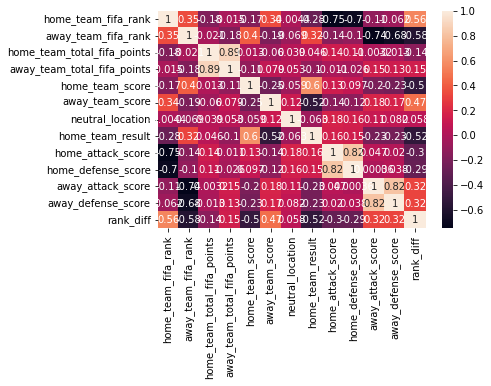

In [64]:
corr = df2_w.corr()
sns.heatmap(corr, annot=True)

In [33]:
df2_w['tournament'].value_counts()

FIFA World Cup qualification    5528
FIFA World Cup                   432
Name: tournament, dtype: int64

In [34]:
df2_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 23890
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         5960 non-null   datetime64[ns]
 1   home_team                    5960 non-null   object        
 2   away_team                    5960 non-null   object        
 3   home_team_fifa_rank          5960 non-null   int64         
 4   away_team_fifa_rank          5960 non-null   int64         
 5   home_team_total_fifa_points  5960 non-null   int64         
 6   away_team_total_fifa_points  5960 non-null   int64         
 7   home_team_score              5960 non-null   int64         
 8   away_team_score              5960 non-null   int64         
 9   tournament                   5960 non-null   object        
 10  neutral_location             5960 non-null   bool          
 11  home_team_result             5960 non-null

In [88]:
target = "home_team_result"

train = df2_w[df2_w['date'].dt.year <= 2016]
val = df2_w[df2_w['date'].dt.year >= 2017]

In [89]:
train[target].value_counts(normalize=True)

1    0.507093
0    0.492907
Name: home_team_result, dtype: float64

In [90]:
train['away_defense_score'] = train['away_defense_score'].fillna(train['away_defense_score'].min())
train['home_defense_score'] = train['home_defense_score'].fillna(train['home_defense_score'].min())
train['home_attack_score'] = train['home_attack_score'].fillna(train['home_attack_score'].min())
train['away_attack_score'] = train['away_attack_score'].fillna(train['away_attack_score'].min())

val['away_defense_score'] = val['away_defense_score'].fillna(val['away_defense_score'].min())
val['home_defense_score'] = val['home_defense_score'].fillna(val['home_defense_score'].min())
val['home_attack_score'] = val['home_attack_score'].fillna(val['home_attack_score'].min())
val['away_attack_score'] = val['away_attack_score'].fillna(val['away_attack_score'].min())

<ipython-input-90-8f2cb781dbbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['away_defense_score'] = train['away_defense_score'].fillna(train['away_defense_score'].min())
<ipython-input-90-8f2cb781dbbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['home_defense_score'] = train['home_defense_score'].fillna(train['home_defense_score'].min())
<ipython-input-90-8f2cb781dbbb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [128]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [130]:
X_train.drop('date',axis = "columns", inplace = True)
X_val.drop('date',axis = "columns", inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [131]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4723 entries, 0 to 19161
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   home_team                    4723 non-null   object 
 1   away_team                    4723 non-null   object 
 2   home_team_fifa_rank          4723 non-null   int64  
 3   away_team_fifa_rank          4723 non-null   int64  
 4   home_team_total_fifa_points  4723 non-null   int64  
 5   away_team_total_fifa_points  4723 non-null   int64  
 6   home_team_score              4723 non-null   int64  
 7   away_team_score              4723 non-null   int64  
 8   tournament                   4723 non-null   object 
 9   neutral_location             4723 non-null   bool   
 10  home_attack_score            4723 non-null   float64
 11  home_defense_score           4723 non-null   float64
 12  away_attack_score            4723 non-null   float64
 13  away_defense_scor

In [125]:
from sklearn.metrics import accuracy_score

base = y_train.mode()[0]
baseline = len(y_train) * [base]
baseline_acc = accuracy_score(y_train, baseline)
print(f'기준모델의 정확도는 {baseline_acc.round(3)} 입니다')

기준모델의 정확도는 0.507 입니다


In [140]:
pipe_1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators = 20,
                          max_depth = 3,
                          n_jobs = -1,
                          random_state = 42,
                          oob_score = True
                          ),
)
pipe_1.fit(X_train, y_train)

print("RandomForestClassifier Acc", pipe_1.score(X_val, y_val))

y_pred = pipe_1.predict(X_val)
print(classification_report(y_val, y_pred))

print("훈련 정확도: ", pipe_1.score(X_train, y_train))
print("검증 정확도: ", pipe_1.score(X_val, y_val))

RandomForestClassifier Acc 0.9037995149555376
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       644
           1       0.91      0.88      0.90       593

    accuracy                           0.90      1237
   macro avg       0.90      0.90      0.90      1237
weighted avg       0.90      0.90      0.90      1237

훈련 정확도:  0.9138259580774931
검증 정확도:  0.9037995149555376


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [141]:
pipe_1.named_steps["randomforestclassifier"].oob_score_

0.8945585432987508

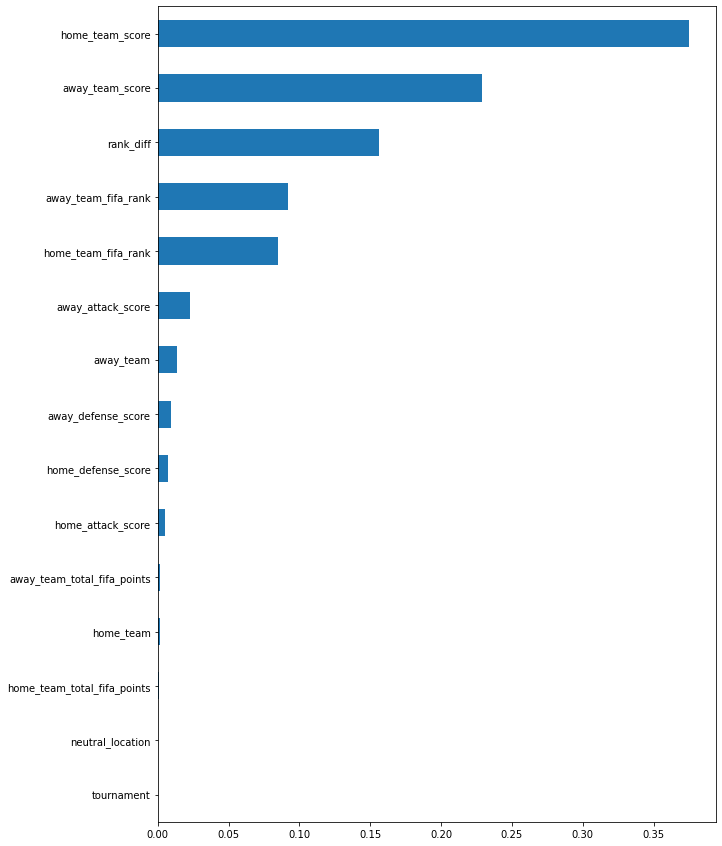

In [162]:
model_rf = pipe_1.named_steps['randomforestclassifier']
importances = pd.Series(model_rf.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 15))
importances.sort_values().plot.barh();

In [160]:
pipe_2 = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=3,
        random_state=42,
        n_jobs=-1,
        max_depth=2,
        learning_rate=0.1,
    ),
)
pipe_2.fit(X_train, y_train)

print("XGBClassifier Acc", pipe_2.score(X_val, y_val))

y_pred = pipe_2.predict(X_val)
print(classification_report(y_val, y_pred))

print("훈련 정확도: ", pipe_2.score(X_train, y_train))
print("검증 정확도: ", pipe_2.score(X_val, y_val))

XGBClassifier Acc 0.8949070331447049
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       644
           1       0.86      0.93      0.89       593

    accuracy                           0.89      1237
   macro avg       0.90      0.90      0.89      1237
weighted avg       0.90      0.89      0.89      1237

훈련 정확도:  0.8981579504552192
검증 정확도:  0.8949070331447049
